## 2023 TBA Predictions

Load the training data into a pandas data frame.  

In [1]:
from __future__ import print_function
import pickle
#import time
import sys
sys.path.append('..')
import swagger_client as v3client
from swagger_client.rest import ApiException
from featurization import addMatch, featurizeMatch, invertMatch, featurizeAlliances

filename = 'matches_2023.pkl'
matches = []
with open(filename, 'rb') as f:
    matches = pickle.load(f)

print(f'{len(matches["matches"])} events')

181 events


Preview a match object

In [2]:
non_empty = [k for k in matches['matches'].keys() if len(matches['matches'][k])>0]
data = [m for k in matches['matches'] for m in matches['matches'][k]]
data = [m for m in data if m.winning_alliance!='' and m.score_breakdown is not None]
print(f'{len(data)} matches')
data[0]
#red = [x for m in data for x in m.alliances.red.team_keys]
#blue = [x for m in data for x in m.alliances.blue.team_keys]
#from collections import Counter
#Counter(red+blue)

2308 matches


{'actual_time': 1677970247,
 'alliances': {'blue': {'dq_team_keys': [],
                        'score': 108,
                        'surrogate_team_keys': [],
                        'team_keys': ['frc4522', 'frc6055', 'frc3937']},
               'red': {'dq_team_keys': [],
                       'score': 131,
                       'surrogate_team_keys': [],
                       'team_keys': ['frc4766', 'frc16', 'frc6586']}},
 'comp_level': 'f',
 'event_key': '2023arli',
 'key': '2023arli_f1m1',
 'match_number': 1,
 'post_result_time': 1677970426,
 'predicted_time': 1677970128,
 'score_breakdown': {'blue': {'activationBonusAchieved': False,
                              'adjustPoints': 0,
                              'autoBridgeState': 'Level',
                              'autoChargeStationPoints': 12,
                              'autoChargeStationRobot1': 'None',
                              'autoChargeStationRobot2': 'None',
                              'autoChargeStation

List the fields in a single alliance match

In [3]:
list(data[0].score_breakdown['blue'].keys())


['activationBonusAchieved',
 'adjustPoints',
 'autoBridgeState',
 'autoChargeStationPoints',
 'autoChargeStationRobot1',
 'autoChargeStationRobot2',
 'autoChargeStationRobot3',
 'autoCommunity',
 'autoDocked',
 'autoGamePieceCount',
 'autoGamePiecePoints',
 'autoMobilityPoints',
 'autoPoints',
 'coopGamePieceCount',
 'coopertitionCriteriaMet',
 'endGameBridgeState',
 'endGameChargeStationPoints',
 'endGameChargeStationRobot1',
 'endGameChargeStationRobot2',
 'endGameChargeStationRobot3',
 'endGameParkPoints',
 'foulCount',
 'foulPoints',
 'linkPoints',
 'links',
 'mobilityRobot1',
 'mobilityRobot2',
 'mobilityRobot3',
 'rp',
 'sustainabilityBonusAchieved',
 'techFoulCount',
 'teleopCommunity',
 'teleopGamePieceCount',
 'teleopGamePiecePoints',
 'teleopPoints',
 'totalChargeStationPoints',
 'totalPoints']

This cell goes into more detail about what's in each field.

In [4]:
#data[0].score_breakdown['blue'].keys()

#endgameFields = Counter()
#taxiFields = Counter()
#for d in data:
#   endgameFields[d.score_breakdown['blue']['endgameRobot1']]+=1
#   endgameFields[d.score_breakdown['blue']['endgameRobot2']]+=1
#   endgameFields[d.score_breakdown['blue']['endgameRobot3']]+=1
#   taxiFields[d.score_breakdown['blue']['taxiRobot1']]+=1
#   taxiFields[d.score_breakdown['blue']['taxiRobot2']]+=1
#   taxiFields[d.score_breakdown['blue']['taxiRobot3']]+=1
#print(endgameFields)
#print(taxiFields)
stats = set()
for d in data:
    for k in d.score_breakdown['blue']:
        v = d.score_breakdown['blue'][k]
        t = type(v)
        if t is int:
            stats.add(k)
        elif t is bool or t is str:
            stats.add(f'{k}.{str(v)}')
        elif t is dict:
            for k2 in v:
                #if type(v[k2]) is list:
                #    for v2 in v[k2]:
                #        stats.add(f'{k}.{k2}.[{v2}]')
                #else:
                #stats.add(f'{k}.{k2}.{str(type(v[k2]))}')
                stats.add(f'{k}.{k2}.{type(v[k2])}')
        elif t is list:
            stats.add(f'{k}.{str(t)}')
            #for v2 in v:
            #    stats.add(f'{k}.[{str(v2)}]')
                
for k in sorted(stats):
    print(k)

activationBonusAchieved.False
activationBonusAchieved.True
adjustPoints
autoBridgeState.Level
autoBridgeState.NotLevel
autoChargeStationPoints
autoChargeStationRobot1.Docked
autoChargeStationRobot1.None
autoChargeStationRobot2.Docked
autoChargeStationRobot2.None
autoChargeStationRobot3.Docked
autoChargeStationRobot3.None
autoCommunity.B.<class 'list'>
autoCommunity.M.<class 'list'>
autoCommunity.T.<class 'list'>
autoDocked.False
autoDocked.True
autoGamePieceCount
autoGamePiecePoints
autoMobilityPoints
autoPoints
coopGamePieceCount
coopertitionCriteriaMet.False
coopertitionCriteriaMet.True
endGameBridgeState.Level
endGameBridgeState.NotLevel
endGameChargeStationPoints
endGameChargeStationRobot1.Docked
endGameChargeStationRobot1.None
endGameChargeStationRobot1.Park
endGameChargeStationRobot2.Docked
endGameChargeStationRobot2.None
endGameChargeStationRobot2.Park
endGameChargeStationRobot3.Docked
endGameChargeStationRobot3.None
endGameChargeStationRobot3.Park
endGameParkPoints
foulCount
fo

In [5]:
from collections import Counter
Counter([x.comp_level for x in data])

Counter({'f': 64, 'qm': 1881, 'sf': 363})

As you can see there is a lot of information here.  We want to collect all of this together so that at the end of the regionals we have score statistics for every team.  We'll sum up all the integer and boolean values and average them over the team's matches.  Grid scores and other dictionary fields will get special treatment.

In [6]:
qualifiers = [x for x in data if x.comp_level=='qm' and x.score_breakdown is not None] 

In [7]:
# This will store all the team statistics
teamAggregates = {}

# Currently just using Week0 events.
for m in qualifiers:
    # only aggregate statistics for regional matches- skip the districts or we're cheating.
    #if m.event_key=='2020pncmp':
    #    continue
    for t in m.alliances.red.team_keys:
        addMatch(t, m, teamAggregates)
    for t in m.alliances.blue.team_keys:
        addMatch(t, m, teamAggregates)
        
# normalize the aggregates
for t in teamAggregates:
    for k in teamAggregates[t]:
        if k=='totalMatches':
            continue
        teamAggregates[t][k]/=teamAggregates[t]['totalMatches']

with open('teamStats_2023.pkl','wb') as f:
    pickle.dump(teamAggregates,f)

In [8]:
teamAggregates['frc16']

{'totalMatches': 12,
 'winCount': 0.75,
 'activationBonusAchievedTotal': 0.75,
 'adjustPointsTotal': 0.0,
 'autoChargeStationPointsTotal': 11.0,
 'autoCommunity.B.Cone.0.Total': 0.0,
 'autoCommunity.B.Cone.1.Total': 0.0,
 'autoCommunity.B.Cone.2.Total': 0.0,
 'autoCommunity.B.Cone.3.Total': 0.0,
 'autoCommunity.B.Cone.4.Total': 0.08333333333333333,
 'autoCommunity.B.Cone.5.Total': 0.16666666666666666,
 'autoCommunity.B.Cone.6.Total': 0.0,
 'autoCommunity.B.Cone.7.Total': 0.0,
 'autoCommunity.B.Cone.8.Total': 0.0,
 'autoCommunity.B.Cube.0.Total': 0.0,
 'autoCommunity.B.Cube.1.Total': 0.0,
 'autoCommunity.B.Cube.2.Total': 0.0,
 'autoCommunity.B.Cube.3.Total': 0.0,
 'autoCommunity.B.Cube.4.Total': 0.08333333333333333,
 'autoCommunity.B.Cube.5.Total': 0.0,
 'autoCommunity.B.Cube.6.Total': 0.0,
 'autoCommunity.B.Cube.7.Total': 0.0,
 'autoCommunity.B.Cube.8.Total': 0.0,
 'autoCommunity.M.Cone.0.Total': 0.0,
 'autoCommunity.M.Cone.1.Total': 0.0,
 'autoCommunity.M.Cone.2.Total': 0.0,
 'autoCom

Now we have statistics for every team.  We can use this to generate features for every match.

In [9]:

features = []

for m in data:
    f = featurizeMatch(m, teamAggregates)
    features.append(f)
    # Optionally invert the red/blue alliances and add this match as well, since it should be symmetric
    features.append(invertMatch(f))
    
features[0]

{'red_missingCount': 0,
 'blue_missingCount': 0,
 'red_totalMatches': 12.0,
 'red_winCount': 0.5833333333333334,
 'red_activationBonusAchievedTotal': 0.7222222222222222,
 'red_adjustPointsTotal': 0.0,
 'red_autoChargeStationPointsTotal': 9.0,
 'red_autoCommunity.B.Cone.0.Total': 0.05555555555555555,
 'red_autoCommunity.B.Cone.1.Total': 0.0,
 'red_autoCommunity.B.Cone.2.Total': 0.0,
 'red_autoCommunity.B.Cone.3.Total': 0.0,
 'red_autoCommunity.B.Cone.4.Total': 0.027777777777777776,
 'red_autoCommunity.B.Cone.5.Total': 0.08333333333333333,
 'red_autoCommunity.B.Cone.6.Total': 0.027777777777777776,
 'red_autoCommunity.B.Cone.7.Total': 0.05555555555555555,
 'red_autoCommunity.B.Cone.8.Total': 0.027777777777777776,
 'red_autoCommunity.B.Cube.0.Total': 0.027777777777777776,
 'red_autoCommunity.B.Cube.1.Total': 0.0,
 'red_autoCommunity.B.Cube.2.Total': 0.0,
 'red_autoCommunity.B.Cube.3.Total': 0.0,
 'red_autoCommunity.B.Cube.4.Total': 0.05555555555555555,
 'red_autoCommunity.B.Cube.5.Total': 

In [10]:
from sklearn.feature_extraction import DictVectorizer
# create train and test sets
train = []
trainY = []
test = []
testY = []

for m in features:    
    if 'event' not in m:
        print(m)
    event = m['event']
    comp_level = m['comp_level']
    del m['event']
    del m['comp_level']
    
    label = m['label']
    del m['label']
    
    #if event == '2019pncmp':
    if comp_level!='qm':
        test.append(m)
        testY.append(label)
    else:
        train.append(m)
        trainY.append(label)
        
vectorizer = DictVectorizer()
trainX = vectorizer.fit_transform(train)
testX = vectorizer.transform(test)

print('{} training examples and {} test'.format(len(train),len(test)))


3762 training examples and 854 test


In [11]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=100, random_state=0, min_samples_split=3)  
classifier.fit(trainX,trainY)
forest_predictions= classifier.predict(testX)
forest_scores = classifier.predict_proba(testX)
import numpy as np
from sklearn.metrics import accuracy_score
#np.sum(np.abs(scores-Ytest))
print('accuracy: {}'.format(accuracy_score(testY, forest_predictions)))
#list(zip(forest_scores[:,1],testY))

# Save the model
model_fn = 'model_2023_forest.pkl'
with open(model_fn, 'wb') as outF:
    pickle.dump((vectorizer,classifier), outF)


accuracy: 0.6967213114754098


Let's look at the feature importances. They tell us how useful a specific feature is.

Feature ranking:


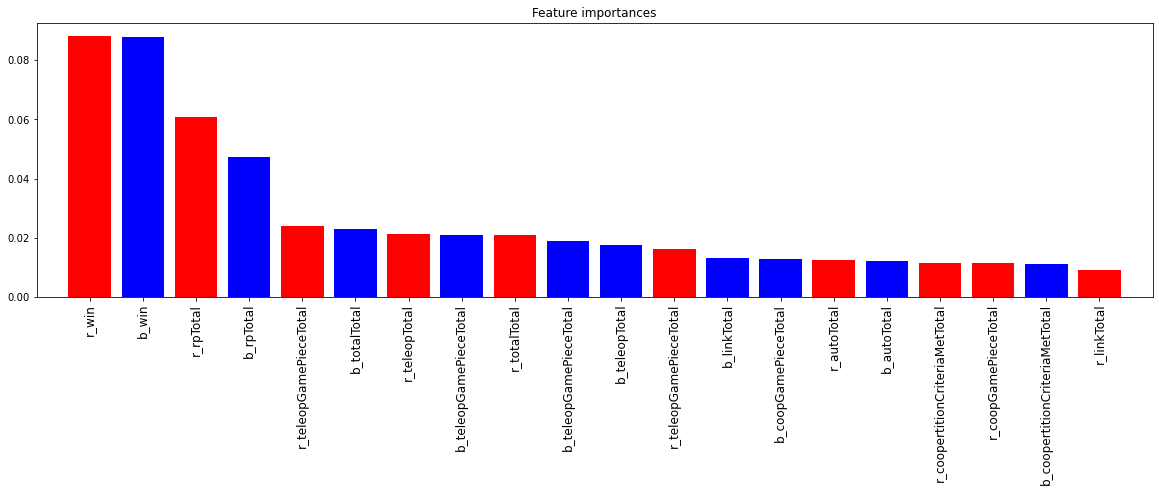

In [12]:
topN = 20
importances = classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in classifier.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1][:topN]
names = vectorizer.feature_names_

# Print the feature ranking
print("Feature ranking:")

#for f in range(trainX.shape[1]):
#    print("%d. %s (%f)" % (f + 1, names[indices[f]], importances[indices[f]]))
colors = [names[f].split('_')[0] for f in indices]
labels = [names[f].replace('Count','').replace('Points','').replace('red','r').replace('blue','b') for f in indices]
# Plot the feature importances of the forest
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)
plt.figure()
plt.title("Feature importances")
#plt.bar(range(trainX.shape[1]), importances[indices],
plt.bar(range(len(indices)), importances[indices],
       color=colors, 
        #yerr=std[indices], 
        align="center")
plt.xticks(range(len(indices)), labels, rotation='vertical', fontsize='large')
    
plt.xlim([-1, len(indices)])
plt.subplots_adjust(bottom=0.5)
#plt.legend()
plt.show()

In [13]:
def percentile(dictionary, key):
    teams = [t for t in dictionary]
    values = [dictionary[t][key] for t in dictionary]
    ranks = sorted(range(len(values)), key=lambda x: values[x])
    return dict([(teams[ranks[i]], i*100/len(values)) for i in range(len(ranks))])    

raw = dict([(k, percentile(teamAggregates,k)) for k in teamAggregates['frc1153']])
#stats = dict([(k,percentile(teamAggregates,k)['frc1153']) for k in teamAggregates['frc1153']])

The next cell enables comparisons between two teams.

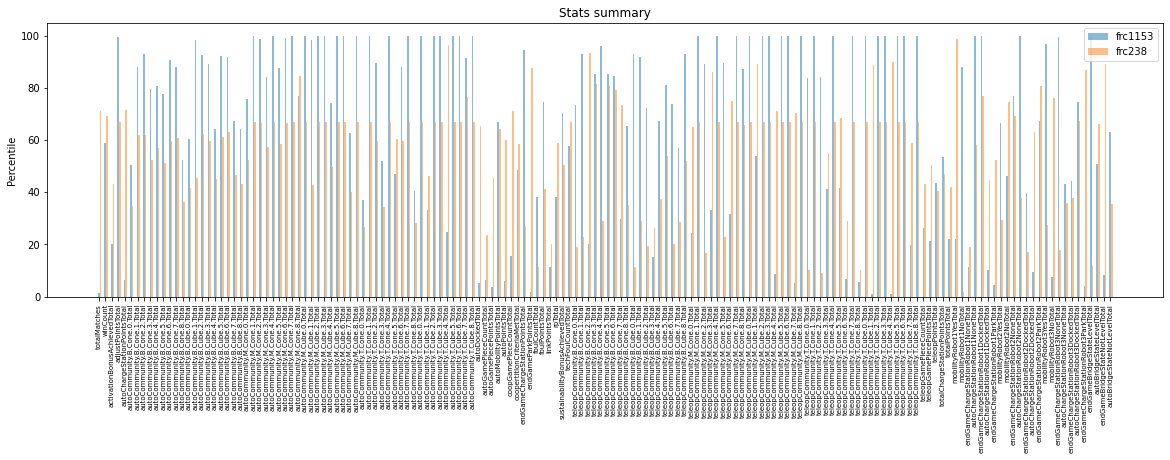

In [14]:
import matplotlib.pyplot as plt
import numpy as np

objects = [k for k in raw]
y_pos = np.arange(len(objects))
#performance = [[raw[k]['frc492'],raw[k]['frc2910']] for k in stats]
#performance
t1 = 'frc1153'
t2 = 'frc238'
plt.figure()
plt.bar(y_pos, [raw[k][t1] for k in raw], alpha=0.5, width=0.25)
plt.bar(y_pos+0.25, [raw[k][t2] for k in raw], alpha=0.5, width=0.25)
plt.xticks(y_pos, objects, rotation=90, fontsize='x-small')
plt.subplots_adjust(bottom=0.5)
plt.ylabel('Percentile')
plt.title('Stats summary')
plt.legend([t1,t2])

plt.show()


## Let's also try logistic regression.

In [15]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter=10000)
classifier.fit(trainX,trainY)
lr_predictions= classifier.predict(testX)
accuracy_score(testY, lr_predictions)

0.6908665105386417

Feature ranking:


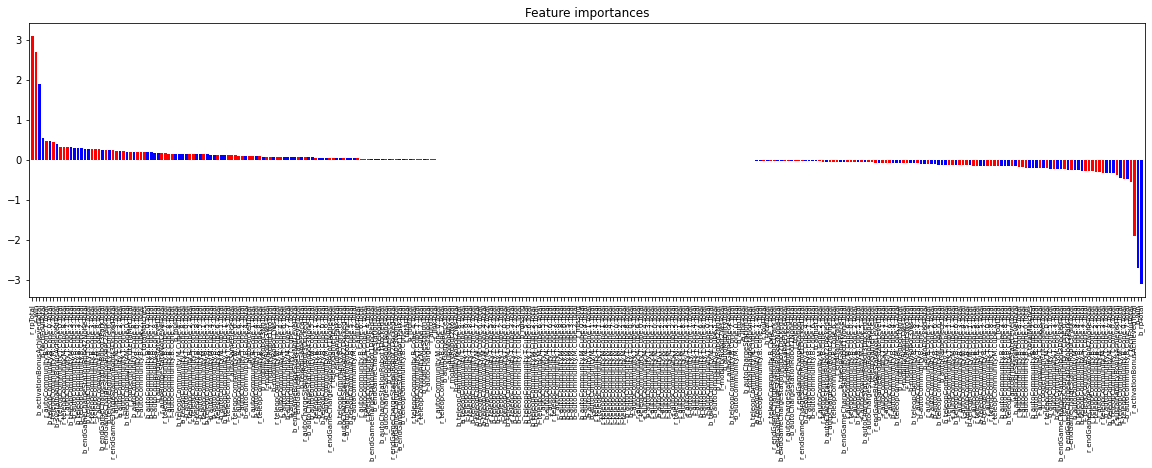

In [16]:
importances = classifier.coef_[0]
#std = np.std([tree.feature_importances_ for tree in classifier.estimators_],
#             axis=0)
indices = np.argsort(importances)[::-1]
names = vectorizer.feature_names_

# Print the feature ranking
print("Feature ranking:")

#for f in range(trainX.shape[1]):
#    print("%d. %s (%f)" % (f + 1, names[indices[f]], importances[indices[f]]))
colors = [names[indices[f]].split('_')[0] for f in range(trainX.shape[1])]
labels = [names[indices[f]].replace('Count','').replace('Points','').replace('red','r').replace('blue','b') for f in range(trainX.shape[1])]
# Plot the feature importances of the forest
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)
plt.figure()
plt.title("Feature importances")
plt.bar(range(trainX.shape[1]), importances[indices],
       color=colors, 
        #yerr=std[indices], 
        align="center")
plt.xticks(range(trainX.shape[1]), labels, rotation='vertical', fontsize='x-small')
    
plt.xlim([-1, trainX.shape[1]])
plt.subplots_adjust(bottom=0.5)
#plt.legend()
plt.show()

## Linear Regression

In [17]:
from sklearn.linear_model import RidgeClassifier
classifier = RidgeClassifier()
classifier.fit(trainX,trainY)
predictions= classifier.predict(testX)
accuracy_score(testY, predictions)

0.6768149882903981

So far our best score at predicting the districts is 0.704 using RandomForests.  Next time we can explore hyperparameter tuning and also predicting which alliances would have been the best ones for us to join.

Next steps: for a given event we want to decide how to prioritize alliance choices.  Suppose we have all the data to date, as well as all the qualifier data for the event. Who should we choose as partners?

In [18]:
# optimize alliances for frc492 at wasno:
import random
from tqdm import tqdm

event = '2023wasno'
teams = set([t for x in \
    [m.alliances.red.team_keys + m.alliances.blue.team_keys for m in matches['matches'][event]] \
        for t in x])

model_fn = 'model_2023_forest.pkl'
with open(model_fn, 'rb') as inF:
    vectorizer, model = pickle.load(inF)

target = 'frc492'
pairs = [(x,y) for x in teams if x!=target for y in teams if y!=target if x<y]
results = {}
features = []
alliances = []
for (x,y) in tqdm(pairs):
    red = [target, x, y]
    candidates = [x for x in teams if x not in red]
    trials = 100
    
    for m in range(trials):
        blue = random.sample(candidates, 3)
        f = featurizeAlliances(teamAggregates, red, blue)
        features.append(f)
        alliances.append([red,blue])

scores = model.predict_proba(vectorizer.transform(features))
results = {}
for ((_,x,y),_), score in zip(alliances, scores): 
    if (x,y) not in results:
        results[(x,y)] = 0
    results[(x,y)] += score[0]    


for r in list(sorted(results, key=lambda x: results[x], reverse=True))[:100]:
    print(r, results[r])

100%|████████████████████████████████████████████████████████████████████████████████| 561/561 [00:38<00:00, 14.67it/s]


('frc2097', 'frc4512') 91.8191666666666
('frc1778', 'frc2097') 91.66349999999997
('frc2097', 'frc5588') 91.50133333333329
('frc2097', 'frc4089') 91.47833333333338
('frc6350', 'frc949') 91.3821666666666
('frc2097', 'frc8248') 91.3411666666667
('frc2097', 'frc6350') 91.33949999999996
('frc2928', 'frc6350') 90.70833333333331
('frc6350', 'frc8248') 90.66499999999998
('frc2097', 'frc3049') 90.53900000000002
('frc2097', 'frc3681') 90.2816666666666
('frc5588', 'frc6350') 90.08333333333334
('frc3681', 'frc6350') 90.0365
('frc2097', 'frc3268') 89.90866666666659
('frc1778', 'frc949') 89.90733333333337
('frc2097', 'frc5941') 89.67450000000001
('frc2097', 'frc949') 89.30633333333328
('frc3268', 'frc5588') 89.24883333333334
('frc3681', 'frc949') 88.99333333333331
('frc1899', 'frc2097') 88.6825
('frc2097', 'frc9036') 88.60549999999998
('frc2097', 'frc2928') 88.43983333333333
('frc4512', 'frc6350') 88.20299999999999
('frc3268', 'frc6350') 88.07599999999998
('frc8248', 'frc949') 87.61816666666662
('fr